In [3]:
# ===============================
# Livestock Emissions ML Analysis
# ===============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import shap
import os

# -------------------------------
# 1. Load the data
# -------------------------------
livestock_df = pd.read_csv("C:\\Projects\\Emissions_Analysis_Capstone\\raw_data\\GLEAM_LivestockEmissions.csv")

# Inspect data
print(livestock_df.head())
print(livestock_df.info())

   Region Animal species  Production system   Commodity  \
0  Global         Cattle         Aggregated  Aggregated   
1  Global         Cattle         Aggregated        Milk   
2  Global         Cattle         Aggregated        Meat   
3  Global         Cattle  Grassland systems  Aggregated   
4  Global         Cattle  Grassland systems        Milk   

   Emission Intensity (kg CO2e per kg protein)  Production (kg protein)  \
0                                        160.3             2.916310e+10   
1                                         86.7             1.888089e+10   
2                                        295.4             1.028222e+10   
3                                        206.3             1.033817e+10   
4                                         95.0             6.940654e+09   

   Total GHG emissions (kg CO2e)  Total CO2 emissions (kg CO2e)  \
0                   4.674630e+12                   9.449299e+11   
1                   1.637519e+12                   2.756914e

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# -------------------------------
# 2. Basic preprocessing
# -------------------------------

# Fill missing values with 0 (or consider more sophisticated imputation)
livestock_df.fillna(0, inplace=True)

# Features and target for regression
numeric_features = [
    "Production (kg protein)",
    "Total CO2 emissions (kg CO2e)",
    "Total CH4 emissions (kg CO2e)",
    "Total N2O emissions (kg CO2e)",
    "Feed, CO2 (kg CO2e)",
    "Feed, CH4 (kg CO2e)",
    "Feed: fertilizer & crop residues, N2O (kg CO2e)",
    "Feed: applied & deposited manure, N2O (kg CO2e)",
    "LUC: soy & palm, CO2 (kg CO2e)",
    "LUC: pasture expansion, CO2 (kg CO2e)",
    "Enteric fermentation, CH4 (kg CO2e)",
    "Manure management, CH4 (kg CO2e)",
    "Manure management, N2O (kg CO2e)",
    "Direct energy, CO2 (kg CO2e)",
    "Indirect energy, CO2 (kg CO2e)",
    "Postfarm, CO2 (kg CO2e)"
]

categorical_features = ["Region", "Animal species", "Production system", "Commodity"]

target = "Emission Intensity (kg CO2e per kg protein)"

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features)
    ]
)

Top drivers of emission intensity

Enteric fermentation, CH₄ (0.448) → This is the largest contributor to emission intensity. Makes sense — methane from cattle digestion is a major GHG source.

Postfarm CO₂ (0.108) → Emissions from processing, transport, and storage also play a significant role.

LUC: soy & palm, CO₂ (0.049) → Land-use change from feed crops is meaningful but smaller than enteric CH₄.

Manure and N₂O sources (~0.04–0.05) → Important but less dominant.

Production (kg protein, 0.039) → Total output has an effect, but not as strong as gas-specific emissions.

Commodity type (Meat) & energy-related CO₂ (~0.03 each) → Indicates that meat systems and energy use have measurable impacts.

In [5]:
# -------------------------------
# 3. Regression Model
# -------------------------------
X = livestock_df[numeric_features + categorical_features]
y = livestock_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred = rf_pipeline.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² score:", r2)
print("RMSE:", rmse)

R² score: 0.8499395781428739
RMSE: 39.80190282739791


Enteric fermentation, CH4 (kg CO2e)                0.447862
Postfarm, CO2 (kg CO2e)                            0.107889
LUC: soy & palm, CO2 (kg CO2e)                     0.048819
Feed: applied & deposited manure, N2O (kg CO2e)    0.044117
Total N2O emissions (kg CO2e)                      0.041361
Production (kg protein)                            0.039116
Commodity_Meat                                     0.031844
Indirect energy, CO2 (kg CO2e)                     0.031380
Direct energy, CO2 (kg CO2e)                       0.026315
Manure management, N2O (kg CO2e)                   0.023997
Feed: fertilizer & crop residues, N2O (kg CO2e)    0.022399
Total CO2 emissions (kg CO2e)                      0.020912
Animal species_Buffaloes                           0.014642
Total CH4 emissions (kg CO2e)                      0.012094
LUC: pasture expansion, CO2 (kg CO2e)              0.010056
dtype: float64


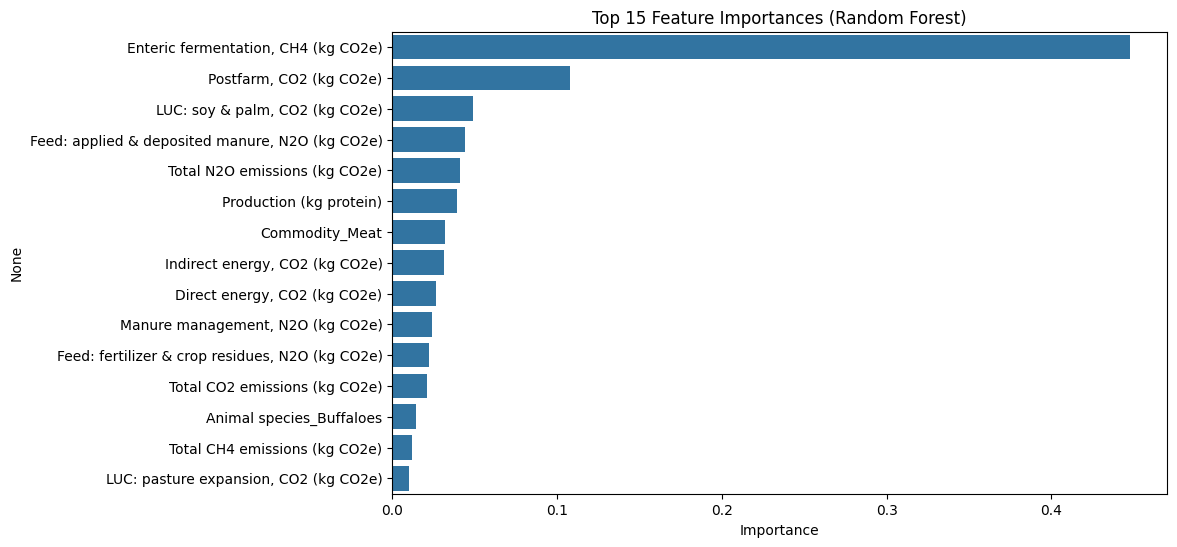

In [6]:
# Get trained regressor from pipeline
regressor = rf_pipeline.named_steps["regressor"]

# numeric_features and categorical_features must match what the pipeline uses
feature_names = numeric_features + list(rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out())

# Extract feature importances
importances = pd.Series(regressor.feature_importances_, index=feature_names).sort_values(ascending=False)

# Print top 15
print(importances.head(15))

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

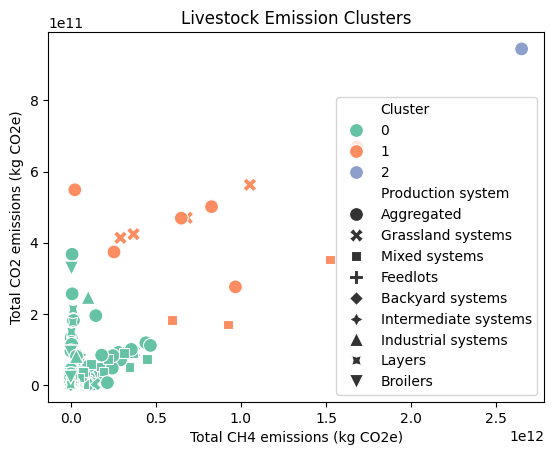

In [7]:
# -------------------------------
# 5. Clustering (Emission Profiles)
# -------------------------------
cluster_features = ["Total CO2 emissions (kg CO2e)", "Total CH4 emissions (kg CO2e)", "Total N2O emissions (kg CO2e)"]
X_cluster = StandardScaler().fit_transform(livestock_df[cluster_features])

kmeans = KMeans(n_clusters=3, random_state=42)
livestock_df["Cluster"] = kmeans.fit_predict(X_cluster)

# Cluster visualization
sns.scatterplot(
    data=livestock_df,
    x="Total CH4 emissions (kg CO2e)",
    y="Total CO2 emissions (kg CO2e)",
    hue="Cluster",
    style="Production system",
    palette="Set2",
    s=100
)
plt.title("Livestock Emission Clusters")
plt.show()


In [8]:

# kmeans.cluster_centers_ gives the scaled feature values; inverse transform to original scale
scaler = StandardScaler().fit(livestock_df[cluster_features])
X_scaled = scaler.transform(livestock_df[cluster_features])

# Compute centroids in original scale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=cluster_features)
centroids_df["Cluster"] = range(len(centroids_df))
print(centroids_df)

cluster_summary = livestock_df.groupby("Cluster")[cluster_features].mean()
print(cluster_summary)

   Total CO2 emissions (kg CO2e)  Total CH4 emissions (kg CO2e)  \
0                   1.492795e+10                   2.817818e+10   
1                   4.164872e+11                   7.572989e+11   
2                   9.449299e+11                   2.648727e+12   

   Total N2O emissions (kg CO2e)  Cluster  
0                   1.455986e+10        0  
1                   3.191586e+11        1  
2                   1.080973e+12        2  
         Total CO2 emissions (kg CO2e)  Total CH4 emissions (kg CO2e)  \
Cluster                                                                 
0                         1.492795e+10                   2.817818e+10   
1                         4.164872e+11                   7.572989e+11   
2                         9.449299e+11                   2.648727e+12   

         Total N2O emissions (kg CO2e)  
Cluster                                 
0                         1.455986e+10  
1                         3.191586e+11  
2                        

In [9]:
cluster_names = {0: "High CH4 Pasture", 1: "Balanced Mixed", 2: "High CO2 Feedlot"}
livestock_df["Cluster_Label"] = livestock_df["Cluster"].map(cluster_names)

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\seaborn\regression.py:315: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\seaborn\regression.py:318: RuntimeWarning: divide by zero encountered in log
  _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


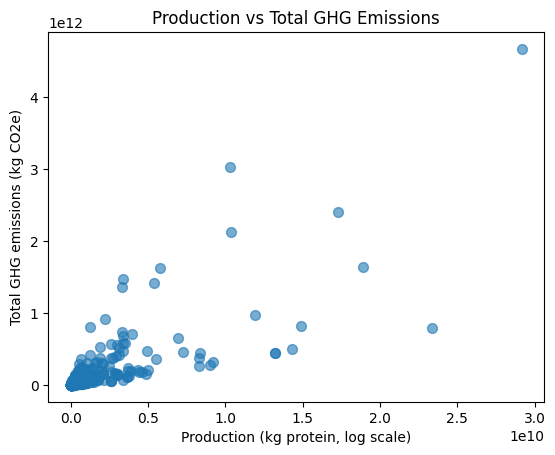

In [10]:
# -------------------------------
# 6. Regression Trend Plot Example
# -------------------------------
sns.regplot(
    data=livestock_df,
    x="Production (kg protein)",
    y="Total GHG emissions (kg CO2e)",
    logx=True,
    scatter_kws={'s':50, 'alpha':0.6}
)
plt.title("Production vs Total GHG Emissions")
plt.xlabel("Production (kg protein, log scale)")
plt.ylabel("Total GHG emissions (kg CO2e)")
plt.show()

c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\seaborn\regression.py:315: RuntimeWarning: divide by zero encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\seaborn\regression.py:318: RuntimeWarning: divide by zero encountered in log
  _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


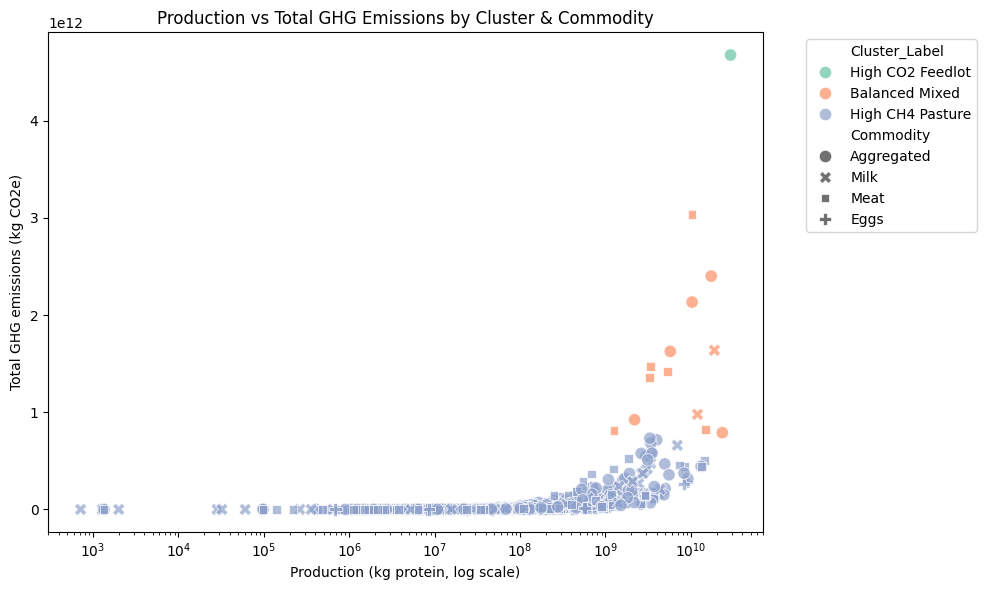

: 

In [ ]:
# Enhanced regression plot with cluster and commodity information
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=livestock_df,
    x="Production (kg protein)",
    y="Total GHG emissions (kg CO2e)",
    hue="Cluster_Label",          # Use descriptive cluster names if you mapped them
    style="Commodity",            # Different marker for Meat, Milk, Aggregated, etc.
    palette="Set2",
    s=80,
    alpha=0.7
)

# Regression trend line (ignores hue/style)
sns.regplot(
    data=livestock_df,
    x="Production (kg protein)",
    y="Total GHG emissions (kg CO2e)",
    logx=True,
    scatter=False,               # Don't duplicate scatter points
    color="black",
    line_kws={"linewidth":2, "linestyle":"--"}
)

plt.xscale('log')                # Ensure log scale
plt.title("Production vs Total GHG Emissions by Cluster & Commodity")
plt.xlabel("Production (kg protein, log scale)")
plt.ylabel("Total GHG emissions (kg CO2e)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)  # Moves legend outside plot
plt.tight_layout()
plt.show()